## Assignment 1 - Recommender Systems

In [1]:
import numpy as np
import pandas as pd
import math
from sklearn.model_selection import train_test_split, KFold
from sklearn.metrics import mean_squared_error, mean_absolute_error
from sklearn.linear_model import LinearRegression

random_seed = 42

ratings = pd.read_table('ml-1m/ratings.dat',  sep = '::', engine = 'python', header = None, names= ['UserID', 'MovieID', 'Rating', 'Timestamp'])

## 1. Recommender Systems

### 1.1 Naive approaches

In [2]:
# Create k-fold indices
kf = KFold(n_splits = 5, shuffle=True, random_state=random_seed)
for train, test in kf.split(ratings):
    print(train, test)

[      1       2       3 ... 1000205 1000207 1000208] [      0       7      12 ... 1000196 1000198 1000206]
[      0       1       2 ... 1000205 1000206 1000208] [      6       9      10 ... 1000192 1000200 1000207]
[      0       1       3 ... 1000205 1000206 1000207] [      2      11      26 ... 1000201 1000204 1000208]
[      0       2       3 ... 1000206 1000207 1000208] [      1       4      16 ... 1000175 1000193 1000199]
[      0       1       2 ... 1000206 1000207 1000208] [      3       5       8 ... 1000202 1000203 1000205]


The three most naive methods: predicting the global average, the average of the user, or the average of the movie.

In [3]:
rmseglobalavg = []
maeglobalavg = []
rmseuseravg = []
maeuseravg = []
rmseitemavg = []
maeitemavg = []

for trainid, testid in kf.split(ratings):
    
    X_train = ratings[['UserID','MovieID']].iloc[trainid]
    X_test = ratings[['UserID','MovieID']].iloc[testid]
    y_train = ratings['Rating'].iloc[trainid]
    y_test = ratings['Rating'].iloc[testid]
    
    # define averages
    global_avg = y_train.mean()
    user_avg = ratings[['UserID','Rating']].iloc[trainid].groupby(['UserID']).mean()
    item_avg = ratings[['MovieID','Rating']].iloc[trainid].groupby(['MovieID']).mean()
 
    # create lists to put results in
    global_avg_pred = []
    user_avg_pred = []
    item_avg_pred = []
    
    # loop over test set
    for x in testid:
       
        # predict using global average
        global_avg_pred.append(global_avg)
    
        # predict using user average
        if ratings['UserID'][x] in user_avg.index.tolist():
            user_rating = user_avg.loc[ratings['UserID'][x]]
            
            # if user rating is outside of [1, 5], change it to 1 or 5
            if user_rating[0] > 5:
                user_avg_pred.append(5)
            elif user_rating[0] < 1: 
                user_avg_pred.append(1)
            else: user_avg_pred.append(user_rating[0])
        else: user_avg_pred.append(global_avg)
        
        # predict using item average
        if ratings['MovieID'][x] in item_avg.index.tolist():
            item_rating = item_avg.loc[ratings['MovieID'][x]]
            
            # if item rating is outside of [1, 5], change it to 1 or 5
            if item_rating[0] > 5:
                item_avg_pred.append(5)
            elif item_rating[0] < 1: 
                item_avg_pred.append(1)
            item_avg_pred.append(item_rating[0])
        else: item_avg_pred.append(global_avg)

    # append results to lists
    rmseglobalavg.append(math.sqrt(mean_squared_error(y_test, global_avg_pred)))
    maeglobalavg.append(mean_absolute_error(y_test, global_avg_pred))
    
    rmseuseravg.append(math.sqrt(mean_squared_error(y_test,user_avg_pred)))
    maeuseravg.append(mean_absolute_error(y_test, user_avg_pred))
    
    rmseitemavg.append(math.sqrt(mean_squared_error(y_test, item_avg_pred)))
    maeitemavg.append(mean_absolute_error(y_test, item_avg_pred))

# print averages of lists
print('global rmse: ', sum(rmseglobalavg)/len(rmseglobalavg))
print('global mae: ', sum(maeglobalavg)/len(maeglobalavg))
print('user rmse: ', sum(rmseuseravg)/len(rmseuseravg))
print('user mae: ', sum(maeuseravg)/len(maeuseravg))
print('item rmse: ', sum(rmseitemavg)/len(rmseitemavg))
print('item mae: ', sum(maeitemavg)/len(maeitemavg))

global rmse:  1.117101450528282
global mae:  0.9338619186570455
user rmse:  1.0354800404316435
user mae:  0.8289498348484926
item rmse:  0.9793666761448853
item mae:  0.7822841972440417


Implementation of two versions of the linear regression algorithm - one with the gamma constant and one without.

In [4]:
# lists to put results in
model1rmseavg = []
model2rmseavg = []
model1maeavg = []
model2maeavg = []

for trainid, testid in kf.split(ratings):
    
    X_train = ratings[['UserID','MovieID']].iloc[trainid]
    X_test = ratings[['UserID','MovieID']].iloc[testid]
    y_train = ratings['Rating'].iloc[trainid]
    y_test = ratings['Rating'].iloc[testid]
    
    # predict using alpha*user + beta*item
    model1 = LinearRegression(fit_intercept = False)
    model1.fit(X_train, y_train)
    pred1 = model1.predict(X_test)
    
    # predict using alpha*user + beta*item + gamma
    model2 = LinearRegression()
    model2.fit(X_train, y_train)
    pred2 = model2.predict(X_test)
    
    # make preds = 5 if > 5, and preds = 1 if < 1
    for idx in range(len(y_test)):
        if pred1[idx] > 5:
            pred1[idx] = 5
        if pred1[idx] < 1:
            pred1[idx] = 1
        if pred2[idx] > 5:
            pred2[idx] = 5
        if pred2[idx] < 1:
            pred2[idx] = 1
            
    # compute rmse and mae
    rmse1 = math.sqrt(mean_squared_error(y_test, pred1))
    mae1 = mean_absolute_error(y_test, pred1)
    rmse2 = math.sqrt(mean_squared_error(y_test, pred2))
    mae2 = mean_absolute_error(y_test, pred2)
    
    # add results to list
    model1rmseavg.append(rmse1)
    model2rmseavg.append(rmse2)
    model1maeavg.append(mae1)
    model2maeavg.append(mae2)
    
# print averages of lists
print('model 1 rmse: ', sum(model1rmseavg)/len(model1rmseavg))
print('model 1 mae: ', sum(model1maeavg)/len(model1maeavg))
print('model 2 rmse: ', sum(model2rmseavg)/len(model2rmseavg))
print('model 2 mae: ', sum(model2maeavg)/len(model2maeavg))

model 1 rmse:  1.72702236357562
model 1 mae:  1.4053592044464092
model 2 rmse:  1.114740675708551
model 2 mae:  0.9301613262832701


### 1.2 UV Matrix Decomposition

Implementation of the UV Matrix Decomposition method.

In [5]:
def compute_RMSE(U_V, M):
    diff = np.subtract(M, U_V)
    RMSE = np.sqrt(np.nansum(np.square(diff))/np.count_nonzero(~np.isnan(M)))
    return RMSE

def compute_MAE(U_V,M):
    diff = np.subtract(M, U_V)
    MAE = np.nansum(np.abs(diff))/np.count_nonzero(~np.isnan(M))
    return MAE

def UV_dec(U, V, M, d):
    #U_r_s
    for r in range(U.shape[0]):
        for s in range(U.shape[1]):
            #only remain non NaN values
            m = M[r,~np.isnan(M[r,:])]
            if(len(m)==0):
                continue
            #retrieve indexes of non NaN values
            idx = np.argwhere(~np.isnan(M[r,:])).reshape(-1)
            v = V[s, idx]
            p = np.dot(U[r,:],V[:, idx]) - (U[r,s] * V[s, idx])
            #update rule
            U[r,s] = np.sum(v*(m-p))/np.sum(np.square(v))
    #V_r_s
    for r in range(V.shape[0]):
        for s in range(V.shape[1]):
            #only remain non NAN values
            m = M[~np.isnan(M[:,s]),s]
            if(len(m)==0):
                continue
            #retrieve indexes of non NaN values
            idx = np.argwhere(~np.isnan(M[:,s])).reshape(-1)
            u = U[idx, r]
            p = np.dot(U[idx,:],V[:,s]) - (U[idx,r] * V[r, s])
            #update rule
            V[r,s] = np.sum(u*(m-p))/np.sum(np.square(u))
    return U,V



In [6]:
kf = KFold(n_splits = 5, random_state=42, shuffle = True)
d = 15
iterations = 10
train_RMSE, test_RMSE = [], []
train_MAE, test_MAE = [], []
for trainid, testid in kf.split(ratings):
    train = ratings.copy()
    #mask test values in training set
    train.loc[testid, "Rating"] = np.nan
    u_m = train.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    M = u_m.to_numpy()
    a = u_m.stack().mean(skipna = True)
    
    test = ratings.copy()
    #mask training values in test set
    test.loc[trainid, "Rating"] = np.nan
    u_m_test = test.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    M_test = u_m_test.to_numpy()

    #initialize U and V
    U = np.full([u_m.shape[0],d], np.sqrt(a/d))
    V = np.full([d,u_m.shape[1]], np.sqrt(a/d))
    compute_RMSE(np.dot(U,V), M)
    for i in range(iterations):
        U, V = UV_dec(U,V,M,d)
        compute_RMSE(np.dot(U,V),M)
        compute_MAE(np.dot(U,V),M)
    
    U_V = np.dot(U,V)
    #post processing: keeping U_V entries between [1,5]
    for i,j in np.ndindex(U_V.shape):
        if(U_V[i,j]<1.0):
            U_V[i,j] = 1.0
        elif(U_V[i,j]>5.0):
            U_V[i,j] = 5.0
        
    train_rmse = compute_RMSE(U_V, M)
    train_mae = compute_MAE(U_V, M)   
    train_RMSE.append(train_rmse)
    train_MAE.append(train_mae)
    test_rmse = compute_RMSE(U_V, M_test)
    test_RMSE.append(test_rmse)
    test_mae = compute_MAE(U_V, M_test)
    test_MAE.append(test_mae)
    
print(np.mean(train_RMSE), "train RMSE")
print(np.mean(train_MAE), "train MAE")
print(np.mean(test_RMSE), "test_RMSE")
print(np.mean(test_MAE), "test MAE")

0.8064098424863932 train RMSE
0.6309833418226154 train MAE
0.8791560414702371 test_RMSE
0.6847957397126184 test MAE


### 1.3 Matrix Factorization

Implementation of the Matrix Factorization method

In [ ]:
kf = KFold(n_splits = 5, random_state=random_seed, shuffle = True)
np.random.seed(42)
eta = 0.005
reg = 0.05
iterations = 75
num_factors = 10
idx = list(range(num_factors))
train_RMSE, test_RMSE = [], []
train_MAE, test_MAE = [], []

for trainid, testid in kf.split(ratings):
    train = ratings.copy()
    #mask test values in training set
    train.loc[testid, "Rating"] = np.nan
    u_m = train.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    X = u_m.to_numpy()

    test = ratings.copy()
    #mask training values in test set
    test.loc[trainid, "Rating"] = np.nan
    u_m_test = test.pivot(index = "UserID", columns = "MovieID", values = "Rating")
    X_test = u_m_test.to_numpy()
    
    #initialize U and M
    U = np.random.uniform(low = -0.01, high = 0.01, size=(u_m.shape[0], num_factors))
    M = np.random.uniform(low = -0.01, high = 0.01, size=(num_factors, u_m.shape[1]))
    compute_RMSE(np.dot(U,M), X)
    compute_MAE(np.dot(U,M), X)
    for run in range(iterations):
        print(run)
        #for each entry in X
        for i, j in np.ndindex(X.shape):
            if(np.isnan(X[i,j])):
                continue
            else:
                #compute prediction
                pred_x =np.dot(U[i,idx], M[idx, j])
                #compute error
                er = X[i,j] - pred_x
                #update rules
                U[i,idx] = [U[i,k] + eta * (2*er * M[k,j] - reg * U[i,k]) for k in range(num_factors)]
                M[idx, j] = [M[k,j] + eta * (2*er * U[i,k] - reg *M[k,j])  for k in range(num_factors)]
        compute_RMSE(np.dot(U,M), X)
        compute_MAE(np.dot(U,M), X)
        
    U_M = np.dot(U,M)
    #post processing: keeping U_V entries between [1,5]
    for i,j in np.ndindex(U_M.shape):
        if(U_M[i,j]<1.0):
            U_M[i,j] = 1.0
        elif(U_M[i,j]>5.0):
            U_M[i,j] = 5.0
    
    train_rmse = compute_RMSE(U_V, X)
    train_mae = compute_MAE(U_V, X)   
    train_RMSE.append(train_rmse)
    train_MAE.append(train_mae)
    test_rmse = compute_RMSE(U_V, X_test)
    test_RMSE.append(test_rmse)
    test_mae = compute_MAE(U_V, X_test)
    test_MAE.append(test_mae)
    
print(np.mean(train_RMSE), "train RMSE")
print(np.mean(train_MAE), "train MAE")
print(np.mean(test_RMSE), "test_RMSE")
print(np.mean(test_MAE), "test MAE")

## 2. Data visualization

The visualization of the data by using three different dimension reduction methods.

In [28]:
import umap.umap_ as umap
import matplotlib.pyplot as plt
import colorcet as cc
from sklearn.decomposition import PCA
from sklearn.manifold import TSNE
from sklearn.neighbors import KNeighborsClassifier
from sklearn.metrics import confusion_matrix, ConfusionMatrixDisplay
import seaborn as sns

In [29]:
# Read in data
users = pd.read_table('ml-1m/users.dat',  sep = '::', engine = 'python', header = None, names= ['ID', 'Gender', 'Age', 'Occupation', 'Zip-code'])
ratings = pd.read_table('ml-1m/ratings.dat',  sep = '::', engine = 'python', header = None, names= ['UserID', 'MovieID', 'Rating', 'Timestamp'])
movies = pd.read_table('ml-1m/movies.dat',  sep = '::', engine = 'python', header = None, names= ['ID', 'Title', 'Genre'], encoding='ISO-8859-1')

In [30]:
# Define dimension reduction methods
pca = PCA(n_components = 2)
youmap = umap.UMAP()
tsne = TSNE()

In [31]:
# read in the matrices
m = pd.read_csv("M3.csv")
u = pd.read_csv("U3.csv")

mmat = m.to_numpy()
umat = u.to_numpy()
mmatswapped = np.swapaxes(mmat,0,1)

print(mmatswapped.shape)
print(umat.shape)

(3706, 10)
(6040, 10)


In [32]:
# Create labels for colors
movies.rename(columns = {'ID':'MovieID'}, inplace = True)
users.rename(columns = {'ID': 'UserID'}, inplace = True)
merged = pd.merge(ratings, movies, on = 'MovieID')
merged = pd.merge(merged, users, on = 'UserID')

movielabel = merged.groupby('MovieID').first()
userlabel = merged.groupby('UserID').first()

movielabel['FirstGenre'] = movielabel['Genre']
movielabel['FirstGenre'] = movielabel['FirstGenre'].apply(lambda x: x.split('|')[0])
print(movielabel)

         UserID  Rating   Timestamp                               Title  \
MovieID                                                                   
1             1       5   978824268                    Toy Story (1995)   
2            18       2   978152541                      Jumanji (1995)   
3            62       3   977904968             Grumpier Old Men (1995)   
4           155       1   977256575            Waiting to Exhale (1995)   
5            48       3   978013996  Father of the Bride Part II (1995)   
...         ...     ...         ...                                 ...   
3948         15       3   978197734             Meet the Parents (2000)   
3949        150       4   995414747          Requiem for a Dream (2000)   
3950        151       3   998696892                    Tigerland (2000)   
3951        195       5  1033617344             Two Family House (2000)   
3952        102       3  1039274093               Contender, The (2000)   

                        

In [33]:
# Apply dimension reduction
tsneuser = tsne.fit_transform(umat)
umapuser = youmap.fit_transform(umat)
pcauser = pca.fit_transform(umat)
tsnemovie = tsne.fit_transform(mmatswapped)
umapmovie = youmap.fit_transform(mmatswapped)
pcamovie = pca.fit_transform(mmatswapped)
print(tsneuser.shape, pcauser.shape, umapuser.shape, tsnemovie.shape, pcamovie.shape, umapmovie.shape)

(6040, 2) (6040, 2) (6040, 2) (3706, 2) (3706, 2) (3706, 2)


Creating different plots based on the dimension reduction.

Text(0.5, 1.0, 'UMAP Dimension Reduction on user matrix, labeled by age')

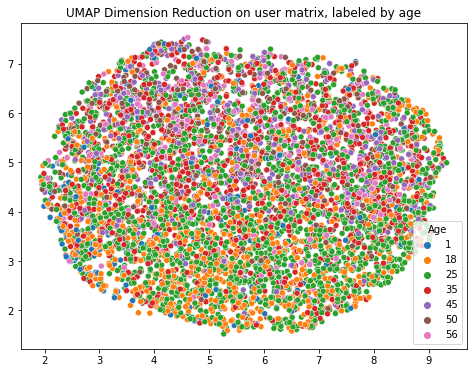

In [43]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapuser[:, 0], y = umapuser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("UMAP Dimension Reduction on user matrix, labeled by age")

Text(0.5, 1.0, 'PCA Dimension Reduction on user matrix, labeled by age')

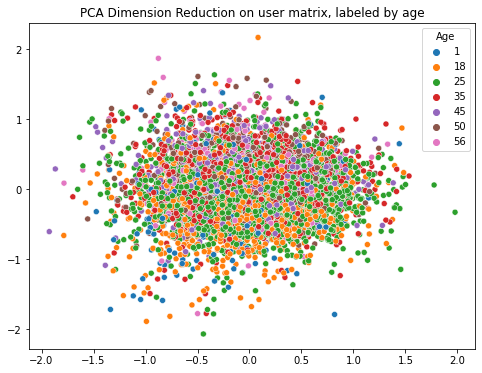

In [44]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcauser[:, 0], y = pcauser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("PCA Dimension Reduction on user matrix, labeled by age")

Text(0.5, 1.0, 'T-SNE Dimension Reduction on user matrix, labeled by age')

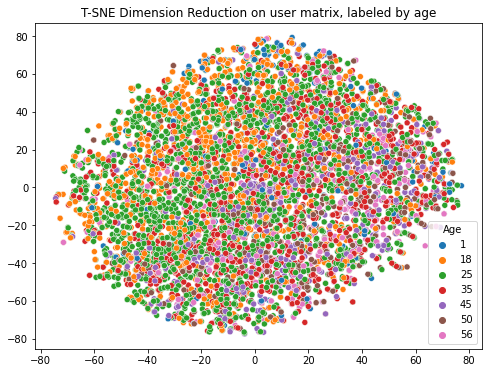

In [45]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsneuser[:, 0], y = tsneuser[:, 1], hue = users['Age'], legend = 'full', palette = sns.color_palette(n_colors=7))
plt.title("T-SNE Dimension Reduction on user matrix, labeled by age")

Text(0.5, 1.0, 'T-SNE Dimension Reduction on movie matrix, labeled by genre')

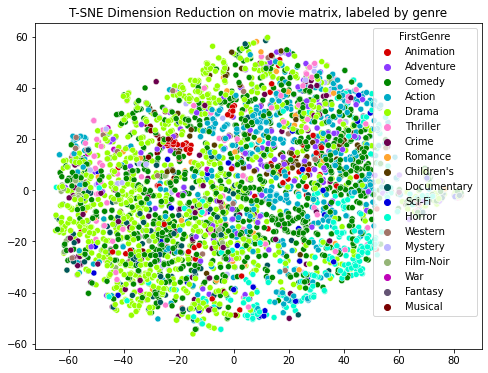

In [46]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsnemovie[:, 0], y = tsnemovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(cc.glasbey, n_colors=18))
plt.title("T-SNE Dimension Reduction on movie matrix, labeled by genre")

Text(0.5, 1.0, 'PCA Dimension Reduction on movie matrix, labeled by genre')

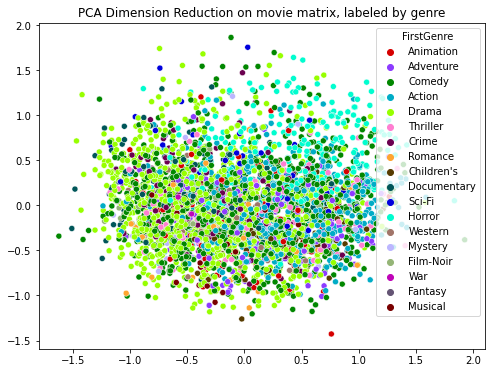

In [47]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcamovie[:, 0], y = pcamovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(cc.glasbey, n_colors=18))
plt.title("PCA Dimension Reduction on movie matrix, labeled by genre")

Text(0.5, 1.0, 'UMAP Dimension Reduction on movie matrix, labeled by genre')

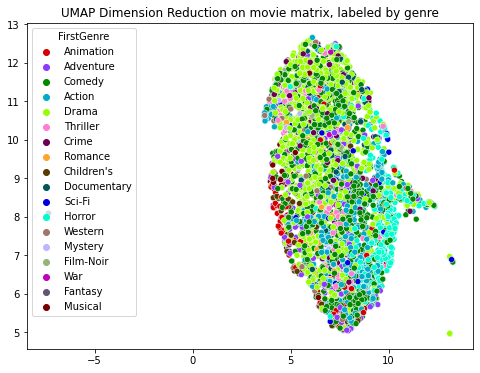

In [48]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapmovie[:, 0], y = umapmovie[:, 1], hue = movielabel['FirstGenre'], palette = sns.color_palette(cc.glasbey, n_colors=18))
plt.title("UMAP Dimension Reduction on movie matrix, labeled by genre")

Text(0.5, 1.0, 'PCA Dimension Reduction on user matrix, labeled by gender')

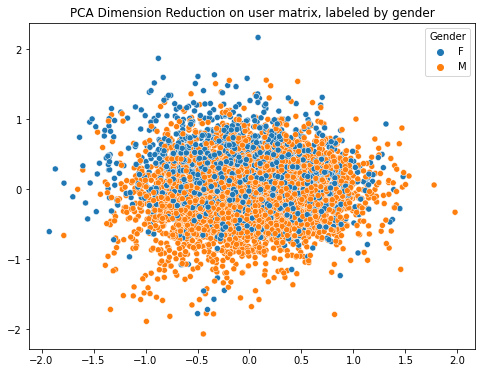

In [49]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = pcauser[:, 0], y = pcauser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("PCA Dimension Reduction on user matrix, labeled by gender")

Text(0.5, 1.0, 'UMAP Dimension Reduction on user matrix, labeled by gender')

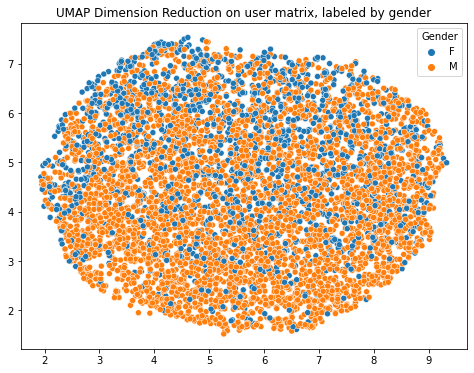

In [50]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = umapuser[:, 0], y = umapuser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("UMAP Dimension Reduction on user matrix, labeled by gender")

Text(0.5, 1.0, 'T-SNE Dimension Reduction on user matrix, labeled by gender')

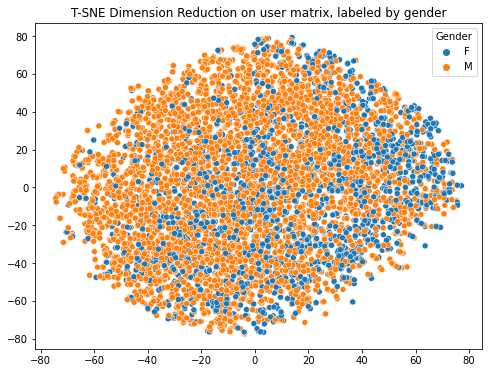

In [51]:
plt.figure(figsize=(8, 6))
sns.scatterplot(x = tsneuser[:, 0], y = tsneuser[:, 1], hue = users['Gender'], legend = 'full', palette = sns.color_palette(n_colors=2))
plt.title("T-SNE Dimension Reduction on user matrix, labeled by gender")